# Double pendulum using Lagrange's equation

Defines a LagrangianPendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

* Last revised 25-Apr-2020 by Carlos Lima.

## Euler-Lagrange equation

For a double pendulum, the Lagrangian with generalized coordinate $\phi$ is

$\begin{align}
  \mathcal{L} = \frac12 (m_1 + m_2) L_1^2 \dot\phi_1^2 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1 - \phi_2) + m_2 L_2^2 \dot\phi_2^2 - (m_1 + m_2) g L_1 (1 - \cos\phi_1) - m_2 g L_2 (1 - \cos\phi_2)
\end{align}$

The Euler-Lagrange equations are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 m_2 L_2 \ddot \phi_2 + m_2 L_1 \ddot \phi_1 \cos(\phi_1 - \phi_2) + m_2 g \sin\phi_2 - m_2 L_1 \dot\phi_1^2 \sin(\phi_1 - \phi_2) = 0
  \;.
\end{align}$


$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 (m_1 + m_2) L_1 \ddot \phi_1 + m_2 L_2 \ddot \phi_2 \cos(\phi_1 - \phi_2) + m_2 L_2 \dot\phi_2^2 \sin(\phi_1 - \phi_2) + (m_1 + m_2)g \sin\phi_1 = 0
 \
  \;.
\end{align}$

In [4]:
%matplotlib inline

In [5]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

# This is an image to the dynamical system given in the equations above.

All of $\begin{align} \theta \end{align}$'s seen in the following image are represented as $\begin{align} \phi \end{align}$'s within the actual program.

I claim no rights to the following image. It is strictly used as a visual aid for educational purposes.

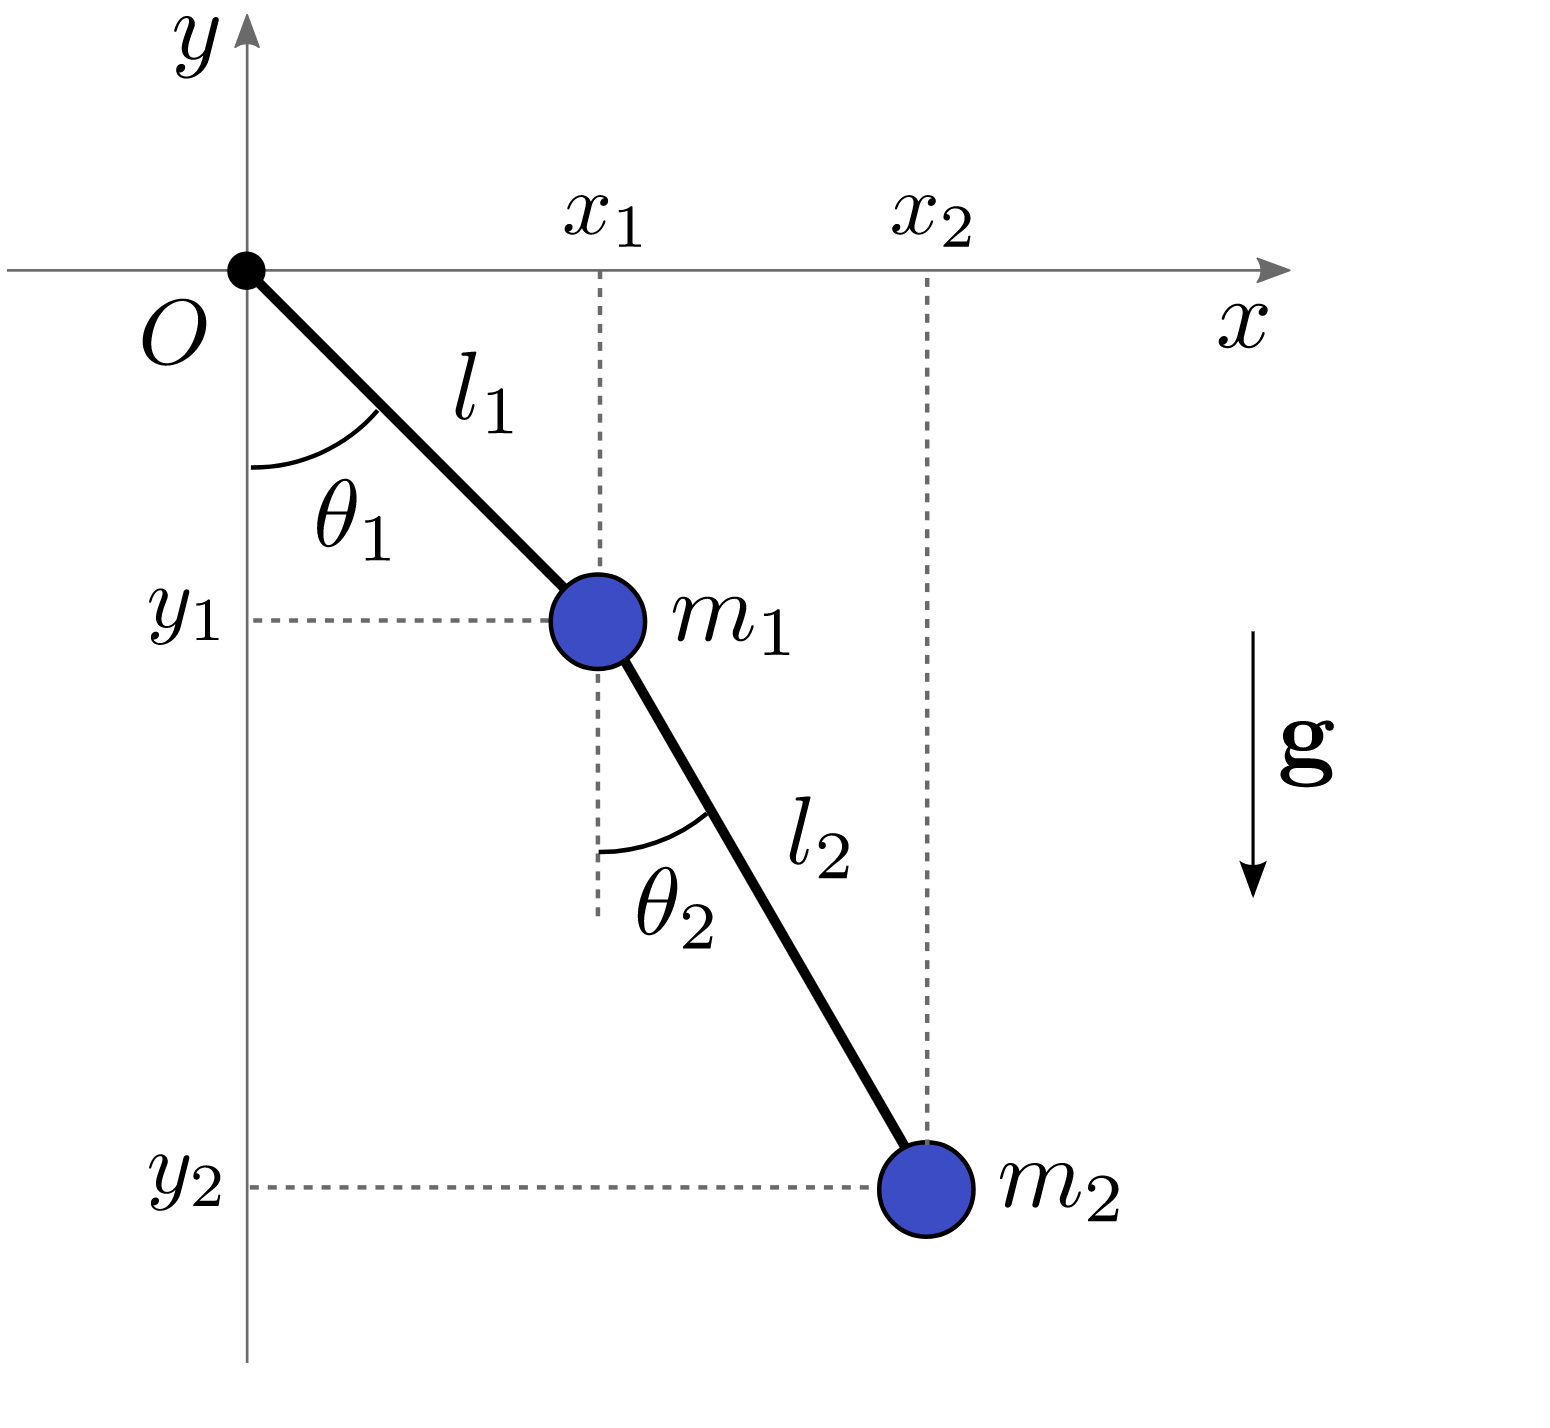

In [6]:
Image(filename='Dub_Pend.png')

# This double pendulum system gives rise to some beautiful geometry. 
The following image illustrates what happens in such a system. When we allow the system to evolve in time, a singular point on the bob attached to only one 
massless rod carves out a chaotic, but wonderful path in $\begin{align} \mathbb{R}^3 \end{align}$ endowed with the Euclidean metric.

I claim no rights to the following image. It is strictly used as a visual aid for educational purposes.

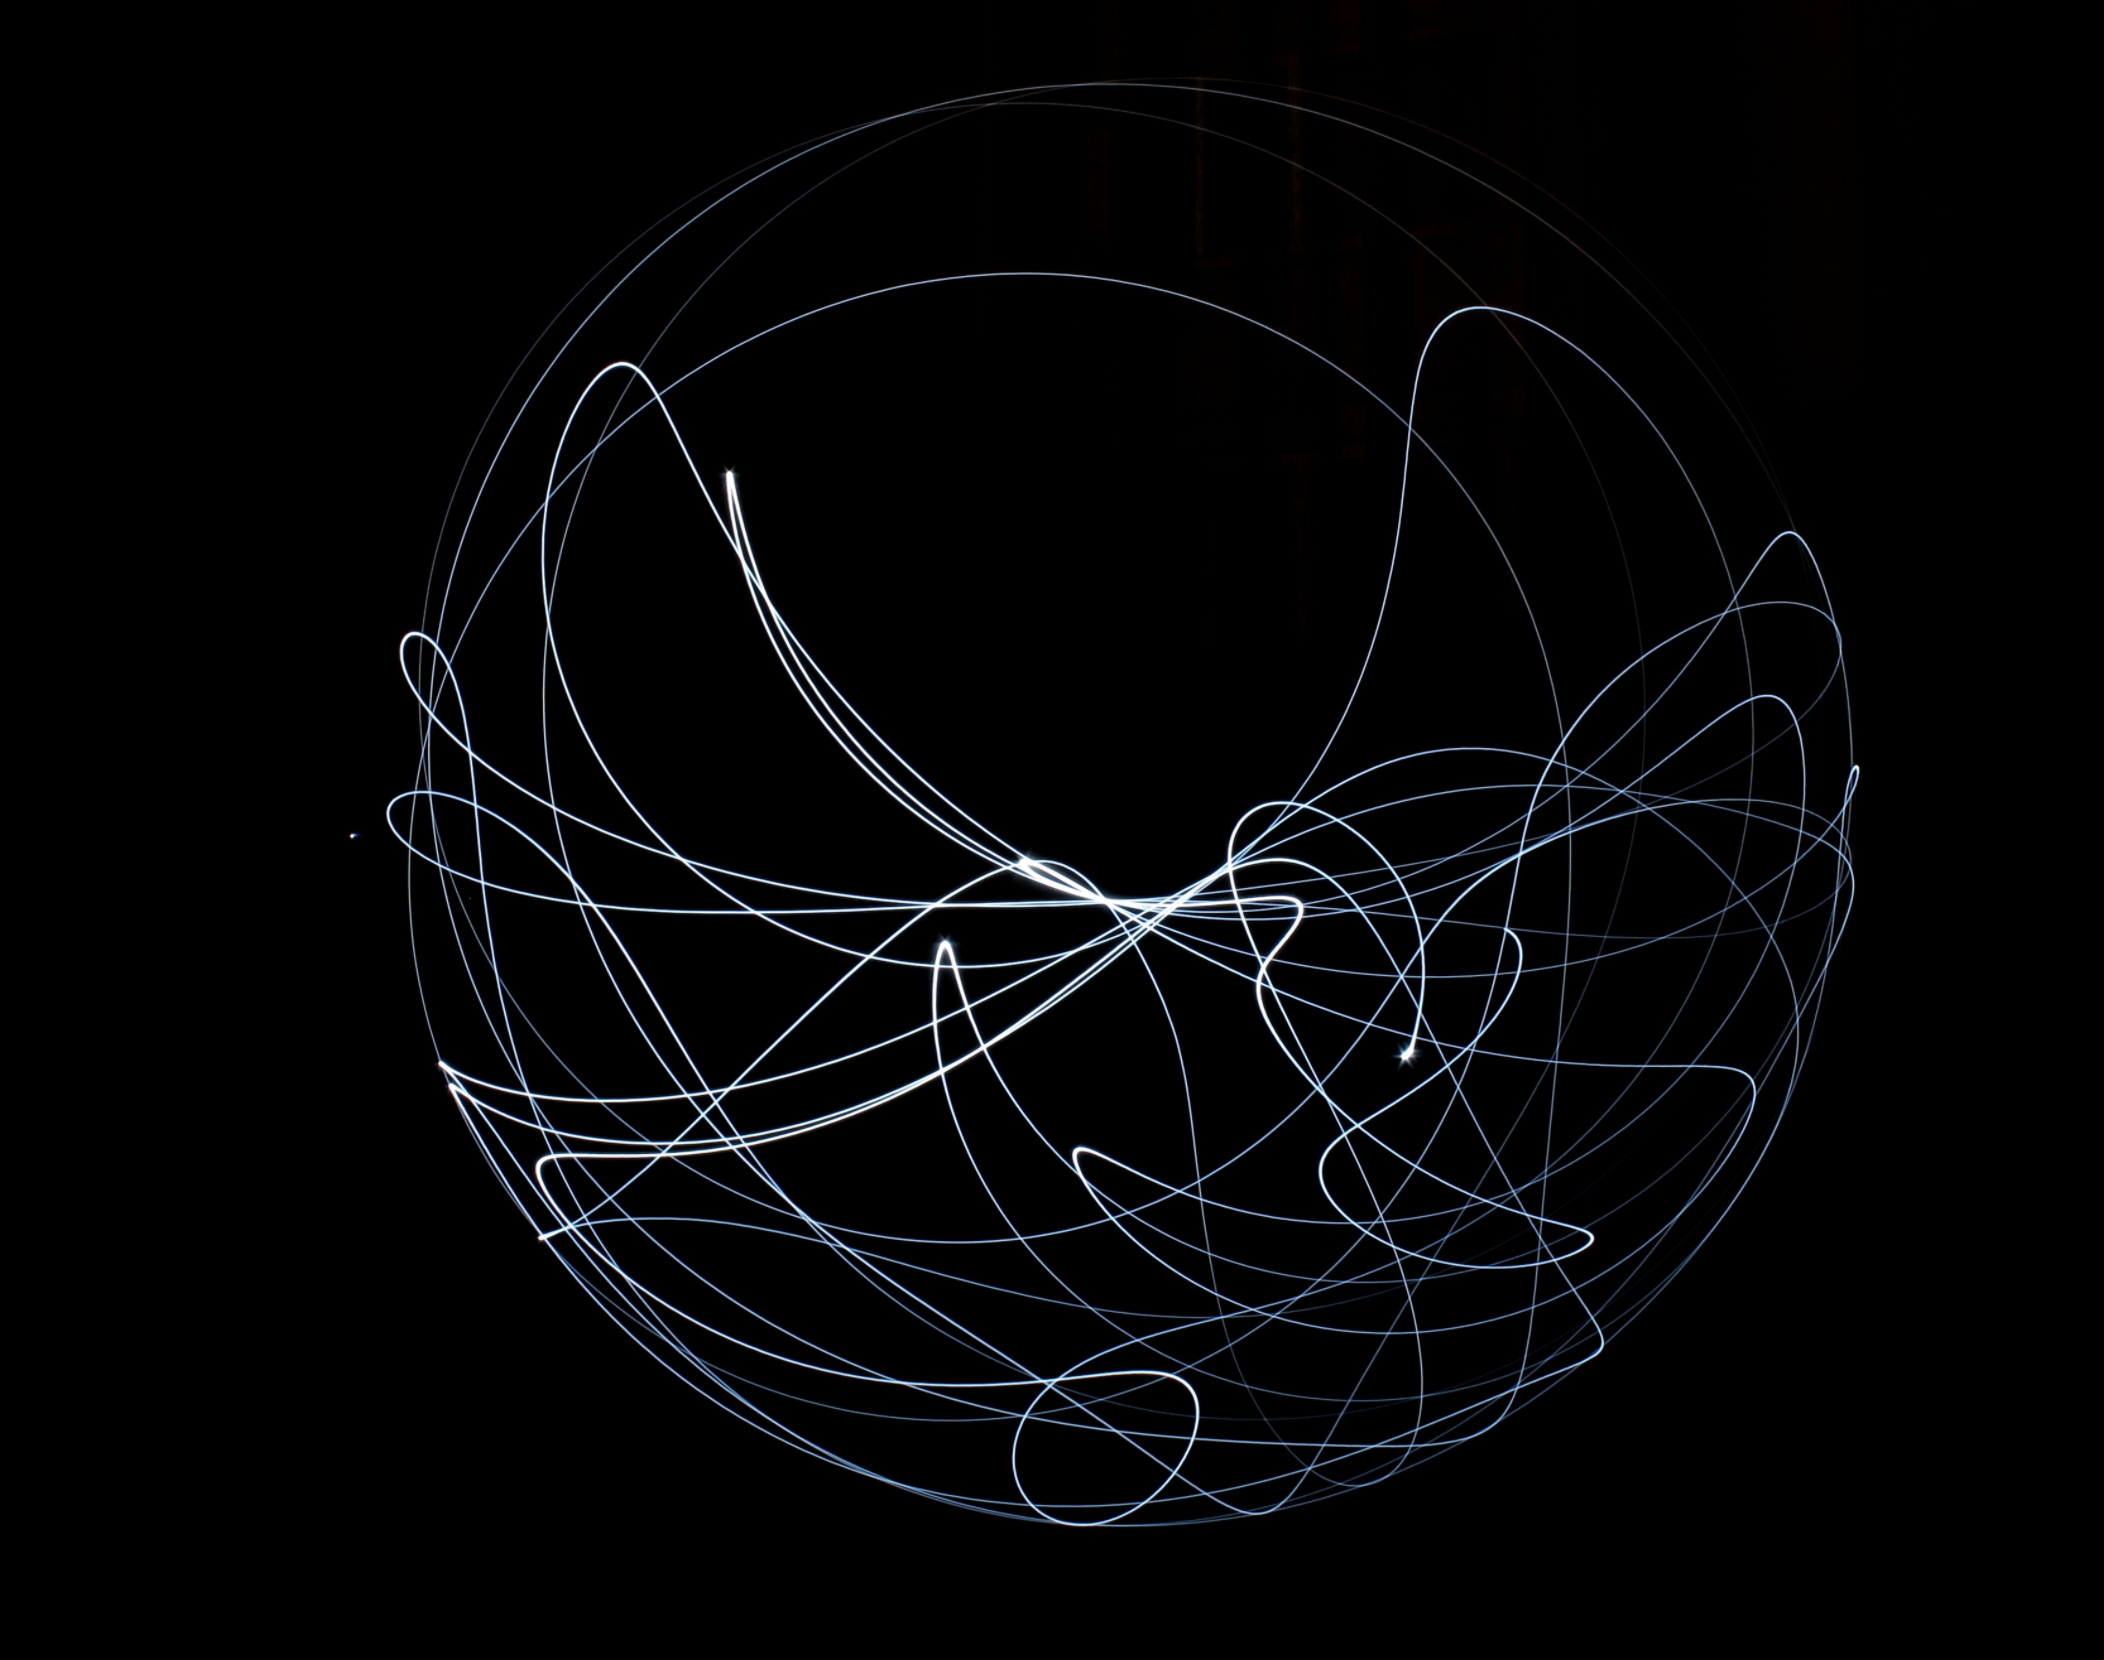

In [7]:
Image(filename='Dub_Pend_Chaos.png')

In [8]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [9]:
class LagrangianDoublePendulum():
    """
    This LagrangianDoublePendulum class implements the parameters and Lagrange's equations for 
    a double pendulum (no driving or damping).
     
    Arguments
    ----------
    L_1, L_2 : float
        lengths of the first and second rods, respetively, on the double pendulum
    g : float
        gravitational acceleration at the earth's surface
    mass_1, mass_2 : float
        mass of first and seond bobs on the double pendulum

    Methods
    -------
    
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
        
    solve_ode(self, t_pts, phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0, abserr=1.0e-9, relerr=1.0e-9)
        This method solve the ordinary differential equation garnered from the Euler-Lagrange formalism.
    """
    def __init__(self, L_1=1.,L_2=1., mass_1=1., mass_2=1., g=1.
                ):
        self.L_1 = L_1
        self.L_2 = L_2
        self.g = g
        self.mass_1 = mass_1
        self.mass_2 = mass_2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq given in the documentation above.
        Which are described by the Euler-Lagrange equations. Not many changes have been made w.r.t.
        the overall structure of the LagragianPendulum class.
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with:
            y[0] = phi_1 and y[1] = phi_1dot
            y[2] = phi_2 and y[3] = phi_2dot
            
        Returns
        -------
        
        """
        
        phi_1, z_1, phi_2, z_2 = y
        
        cos, sin = np.cos(phi_1 - phi_2), np.sin(phi_1 - phi_2)
        q = (self.mass_1 + self.mass_2 * sin**2)
        
        phi_1dot = z_1
        z_1dot = (self.mass_2 * self.g * np.sin(phi_2) * cos - self.mass_2 * sin * (self.L_1 * z_1**2 * cos + self.L_2 * z_2**2) \
                  - (self.mass_1 + self.mass_2) * self.g *np.sin(phi_1)) / self.L_1 / q
        
        phi_2dot = z_2
        z_2dot = ((self.mass_1 + self.mass_2) * (self.L_1 * z_1**2 * sin - self.g * np.sin(phi_2) + self.g * np.sin(phi_2) * cos)
                 + self.mass_2 * self.L_2 * z_2**2 * sin * cos) / self.L_2 / q
        
        return phi_1dot, z_1dot, phi_2dot, z_2dot
    
    def solve_ode(self, t_pts, phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_1dot, phi_2, phi_2dot = solution.y

        return phi_1, phi_1dot, phi_2, phi_2dot

In [10]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [11]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## All the code above for plotting has remained the same from original 'Lagragian Pendulum' Notebook 

# Make plots for the double pendulum given a set of initial conditions (IC).
Make plots of $\begin{align} \phi(t) \end{align}$ versus time $\begin{align} t \end{align}$

In [12]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
#phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
#state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L_1 = 1.
L_2 = 1.

g = 1.
mass_1 = 1.
mass_2 = 1.

# Instantiate a pendulum from our class above
dubp1 = LagrangianDoublePendulum(L_1=L_1, L_2=L_2, g=g, mass_1=mass_1, mass_2=mass_2)


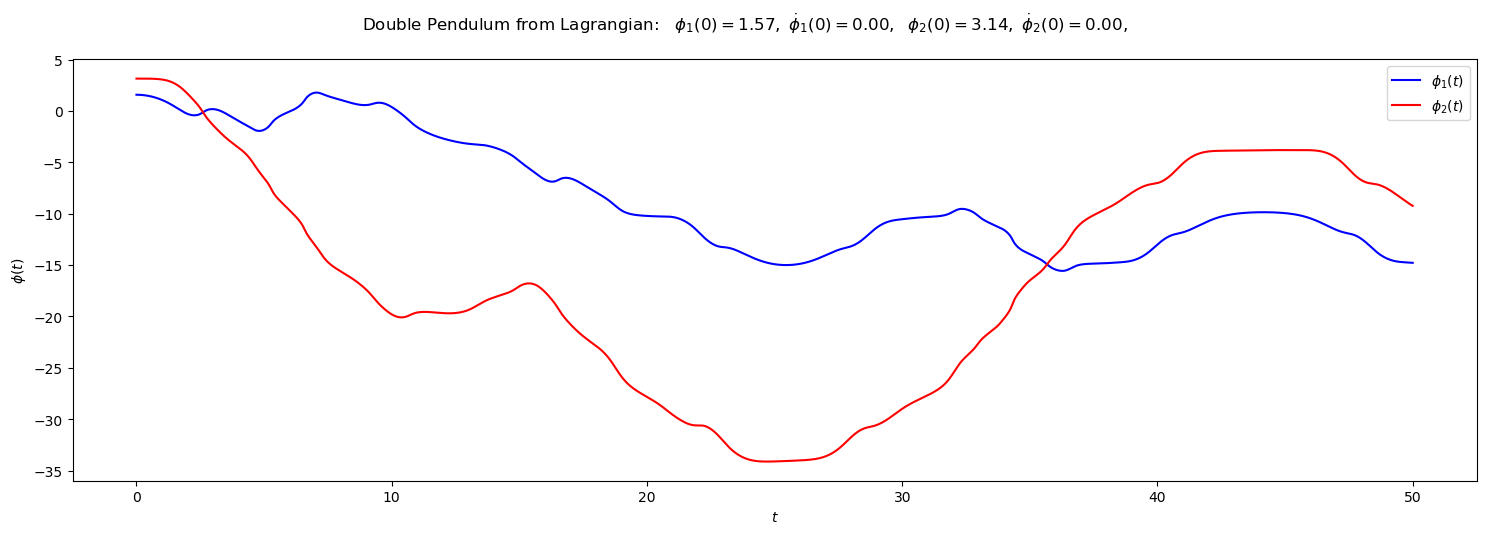

In [13]:
# both plots: given different IC's
phi_1_0 = np.pi/2.
phi_1dot_0 = 0.
phi_2_0 = np.pi
phi_2dot_0 = 0.
phi_1, phi_1dot, phi_2, phi_2dot = dubp1.solve_ode(t_pts, phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double Pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1dot_0:.2f},$' + \
                rf'  $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_1dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot of phi_1 and phi_2: phi plot with above IC's 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label=r'$\phi_1(t)$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label=r'$\phi_2(t)$', 
            ax=ax_a)   
                           
    
fig.tight_layout()
fig.savefig('Double_Pendulum_Lagrangian_1.png', bbox_inches='tight')
# second plot: phi_dot plot 
# ax_b = fig.add_subplot(1,3,2)                  

# start, stop = start_stop_indices(t_pts, t_start, t_end)    
# plot_y_vs_x(t_pts[start : stop], phi_dot[start : stop], 
#             axis_labels=phi_vs_time_labels, 
#             color='blue',
#             label=None, 
#             title=r'$\phi_2(t)$', 
#             ax=ax_b)    

# third plot: state space plot from t=30 to t=50   
# ax_c = fig.add_subplot(1,3,3)                  

# start, stop = start_stop_indices(t_pts, t_start, t_end)    
# plot_y_vs_x(phi[start : stop], phi_dot[start : stop], 
#             axis_labels=state_space_labels, 
#             color='blue',
#             label=None, 
#             title='State space', 
#             ax=ax_c)    

# fig.tight_layout()
# fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

# Plotting Chaos
In the following block of code we attempt to generate semi-log plots for $\begin{align} \left\| \phi(t) \right\| \end{align}$
versus time $\begin{align} t \end{align}$.

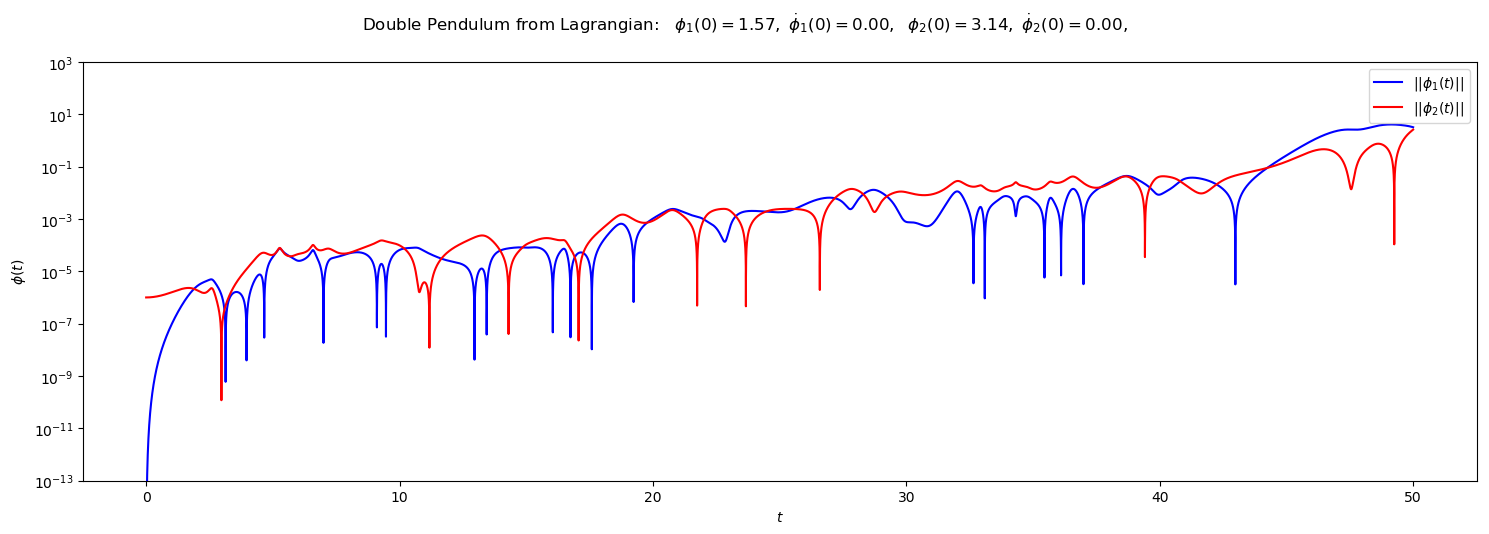

In [14]:
phi_1_0 = np.pi/2
phi_1dot_0 = 0.
phi_2_0 = np.pi
phi_2dot_0 = 0.

phi_1, phi_1dot, phi_2, phi_2dot = dubp1.solve_ode(t_pts, phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0)
phi_1_abs, phi_1dot_abs, phi_2_abs, phi_2dot_abs = dubp1.solve_ode(t_pts, phi_1_0, phi_1dot_0, phi_2_0-0.000001, phi_2dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double Pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1dot_0:.2f},$' + \
                rf'  $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_1dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(phi_1[start : stop]- phi_1_abs[start : stop]), 
            axis_labels=phi_vs_time_labels, 
            color='blue', semilogy=True,
            label=r'$||\phi_1(t)||$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], np.abs(phi_2[start : stop]-phi_2_abs[start : stop]),  
            color='red', semilogy=True,
            label=r'$||\phi_2(t)||$', 
            ax=ax_a)   
                           
ax_a.set_ylim(1.e-13, 1.e3)
fig.tight_layout()
fig.savefig('Double_Pendulum_Lagrangian_AbsVal_SemiLog1.png', bbox_inches='tight')

## Does a log-log plot tell us anything else?
Not really. The same chaotic behavior remains even on a log-log scale, which we would expect.

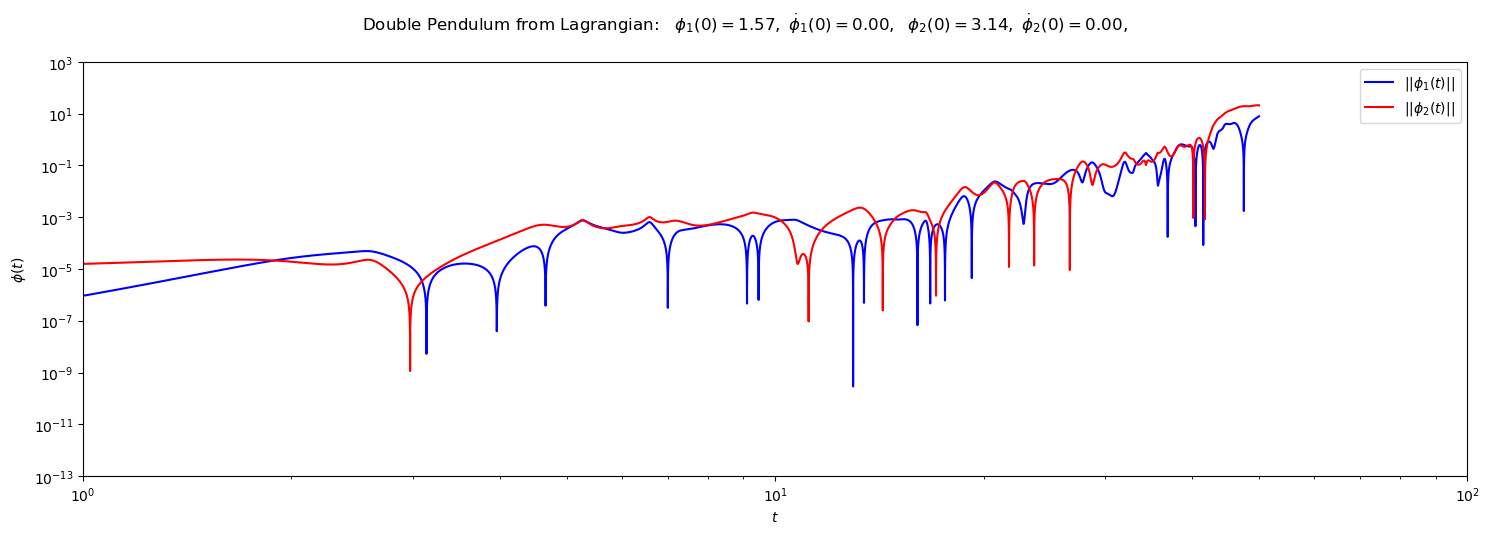

In [15]:
phi_1_0 = np.pi/2
phi_1dot_0 = 0.
phi_2_0 = np.pi
phi_2dot_0 = 0.

phi_1, phi_1dot, phi_2, phi_2dot = dubp1.solve_ode(t_pts, phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0)
phi_1_abs, phi_1dot_abs, phi_2_abs, phi_2dot_abs = dubp1.solve_ode(t_pts, phi_1_0, phi_1dot_0, phi_2_0-0.00001, phi_2dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double Pendulum from Lagrangian:  ' + \
                rf' $\phi_1(0) = {phi_1_0:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_1dot_0:.2f},$' + \
                rf'  $\phi_2(0) = {phi_2_0:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_1dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.abs(phi_1[start : stop]- phi_1_abs[start : stop]), 
            axis_labels=phi_vs_time_labels, 
            color='blue', loglog=True,
            label=r'$||\phi_1(t)||$', 
            ax=ax_a)  
plot_y_vs_x(t_pts[start : stop], np.abs(phi_2[start : stop]-phi_2_abs[start : stop]),  
            color='red', loglog=True,
            label=r'$||\phi_2(t)||$', 
            ax=ax_a)   
                           
ax_a.set_ylim(1.e-13, 1.e3)
ax_a.set_xlim(1.e0, 1.e2)

fig.tight_layout()
fig.savefig('Double_Pendulum_Lagrangian_AbsVal_LogLog1.png', bbox_inches='tight')

## Widgets!!!
We'll attempt to use widgets to see how the behavior of the Lagragian double pendulum changes when we change the parameters of the system!

In [20]:
# Import the widgets we will use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display
from time import sleep

In [21]:
phi_1_0 = np.pi/2
phi_1dot_0 = 0.
phi_2_0 = np.pi
phi_2dot_0 = 0.

In [22]:
# This function generates the main output, which is a grid of plots
def pendulum_plots(phi_1_vs_time_plot=True, phi_1dot_vs_time_plot=True, 
                   phase_space_plot=True, g=1., 
                   mass_1=1., mass_2=1., L_1=0.689, L_2=1., 
                   phi_1_0=np.pi/2, phi_1dot_0=0., phi_2_0 = np.pi, phi_2dot_0 = 0.,
                   t_start=0, t_end=100, delta_t=0.1, plot_start=0,
                   animate_flag=False, t_index=0,
                   font_size=18):
    """
    Create plots for interactive_output according to the inputs.
    
    Based on generating a Pendulum instance and the requested graphs.
    
    Notes
    -----
        1. We generate a new Pendulum instance every time *and* solved
            the ODE every time, even if the only change is to parameters
            like t_start and t_end.  Should we care or is this just so
            cheap to recalculate that it doesn't matter?
            How could we structure this differently?
    """
    
    # add delta_t o it goes at least to t_end (probably should use linspace)
    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  
        
    # Instantiate a pendulum with the passed (or default) values of the 
    #  natural frequency omega0, damping alpha, driving amplitude, frequency, 
    #  and phase (f_ext, omega_ext, phi_ext).
    #  Should we delete p1 at some point?  Is there a memory issue?
    p1 = LagrangianDoublePendulum(L_1=L_1,L_2=L_2, mass_1=mass_1, mass_2=mass_2, g=g)
    
    y0 = [phi_1_0, phi_1dot_0, phi_2_0, phi_2dot_0]  # initial conditions for the Lagrangian Double Pendulum ODE

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # For now we solve with odeint; give more options in the future.
    phi_1, phi_1dot, phi_2, phi_2dot = odeint(p1.dy_dt, y0, t_pts,
                              atol=abserr, rtol=relerr).T
    
    # Update the common font size
    plt.rcParams.update({'font.size': font_size})
 
    # Labels for individual plot axes
    phi_vs_time_labels = (r'$t$', r'$\phi$')
    phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt$')
    phase_space_labels = (r'$\theta$', r'$d\tphi/dt$')
    
    # Figure out how many rows and columns [one row for now]
    plot_flags = [phi_1_vs_time_plot, phi_1dot_vs_time_plot, phase_space_plot]
    plot_num = plot_flags.count(True)
    plot_rows = 1
    figsize_rows = plot_rows*6
    plot_cols = plot_num
    figsize_cols = min(plot_cols*8, 16)  # at most 16
    
    # Make the plot!
    fig, axes = plt.subplots(plot_rows, plot_cols, 
                             figsize=(figsize_cols,figsize_rows))
    axes = np.atleast_1d(axes)  # make it always a 1d array, even if only 1

    start_index = (np.fabs(t_pts-plot_start)).argmin() # finds nearest index
    
    next_axes = 0
    if phi_1_vs_time_plot:
        plot_y_vs_x(t_pts, phi_1, axis_labels=phi_1_vs_time_labels, 
                    label='pendulum', title=r'$\theta$ vs. time', 
                    ax=axes[next_axes])    
        # add a line where the phase space plot starts
        axes[next_axes].axvline(t_pts[start_index], lw=3, color='red')
        if animate_flag:
            axes[next_axes].plot(t_pts[t_index], phi_1[t_index], 'ro')
        next_axes += 1
    
    if phi_1dot_vs_time_plot:
        plot_y_vs_x(t_pts, phi_1dot, axis_labels=phi_1dot_vs_time_labels, 
                    label='pendulum', title=r'$d\phi/dt$ vs. time', 
                    ax=axes[next_axes])    
        # add a line where the phase space plot starts
        axes[next_axes].axvline(t_pts[start_index], lw=3, color='red')
        if animate_flag:
            axes[next_axes].plot(t_pts[t_index], phi_1dot[t_index], 'ro')
        next_axes += 1

    if phase_space_plot:
        plot_y_vs_x(phi_1[start_index:-1], phi_1dot[start_index:-1], 
                    axis_labels=phase_space_labels, title='Phase space', 
                    ax=axes[next_axes])    
        if animate_flag:
            axes[next_axes].plot(phi_1[t_index], phi_1dot[t_index], 'ro')
        next_axes += 1
    
    fig.tight_layout()
    
    return fig, axes


In [23]:
# Widgets for the various inputs.
#   For any widget, we can set continuous_update=False if we don't want the 
#    plots to shift until the selection is finished (particularly relevant for 
#    sliders).

# Widgets for the plot choice (plus a label out front)
plot_choice_w = Label(value='Which plots: ',layout=Layout(width='100px'))
def plot_choice_widget(on=True, plot_description=None):
    """Makes a Checkbox to select whether to show a plot."""
    return Checkbox(value=on, description=plot_description,
                  disabled=False, indent=False, layout=Layout(width='150px'))
phi_1_vs_time_plot_w = plot_choice_widget(True, r'$\phi_1$ vs. time')
phi_1dot_vs_time_plot_w = plot_choice_widget(False, r'$d\phi_1/dt$ vs. time')
phase_space_plot_w = plot_choice_widget(True, 'phase space')

# Widgets for the pendulum parameters (all use FloatSlider, so made function)
def float_widget(value, min, max, step, description, format):
    """Makes a FloatSlider with the passed parameters and continuous_update
       set to False."""
    slider_border = Layout(border='solid 1.0px')
    return FloatSlider(value=value,min=min,max=max,step=step,disabled=False,
                       description=description,continuous_update=False,
                       orientation='horizontal',layout=slider_border,
                       readout=True,readout_format=format)

g_w = float_widget(value=1.0, min=0.0, max=10., step=0.1,
                        description=r'natural $g$:', format='.1f')
mass_1_w = float_widget(value=0.1, min=0.0, max=2., step=0.1,
                       description=r'damping $m_1$:', format='.1f')
mass_2_w = float_widget(value=0.2, min=0.0, max=2., step=0.05,
                       description=r'strength $m_2$:', format='.2f')
L_1_w = float_widget(value=0.689,min=0.0,max=3.,step=0.1,
                       description=r'freq. $L_1$:', format='.2f')
L_2_w = float_widget(value=0.0, min=0, max=2.*np.pi, step=0.1,
                         description=r'phase $L_2$:', format='.1f')

# Widgets for the initial conditions
phi_1_0_w = float_widget(value=0.8, min=0., max=2.*np.pi, step=0.1,
                        description=r'$\phi_1_0$:', format='.1f')
phi_1dot_0_w = float_widget(value=0.0, min=-10., max=10., step=0.1,
                            description=r'$(d\phi_1_0/dt)_0$:', format='.1f')

# Widgets for the plotting parameters
t_start_w = float_widget(value=0., min=0., max=100., step=10.,
                         description='t start:', format='.1f') 
t_end_w = float_widget(value=100., min=0., max=500., step=10.,
                       description='t end:', format='.1f')
delta_t_w = float_widget(value=0.1, min=0.01, max=0.2, step=0.01,
                         description='delta t:', format='.2f')
plot_start_w = float_widget(value=0., min=0., max=300., step=5.,
                            description='start plotting:', format='.1f')

# Widgets for the animating
animate_flag_w = Checkbox(value=False, description='Animate',
                  disabled=False, indent=False, layout=Layout(width='100px'))
t_index_w = Play(interval=100, value=0, min=0, max=1000, step=1, 
                      disabled=True, continuous_update=True,
                      description='press play', 
                      orientation='horizontal')

# Widgets for the styling parameters
font_size_w = Dropdown(options=['12', '16', '18', '20', '24'], value='18',
                       description='Font size:',disabled=False,
                       continuous_update=False,layout=Layout(width='140px'))

# Text for the help section in HTML (could move this to an external file!)
overview_text = \
   r"""<p>Here we explore the dynamics of a damped, driven pendulum. There is help 
          available under the other tabs.</p>  
          <ul>
            <li>Physics tab: find out about the equations being solved.
            <li>Plotting tab: adjust what is plotted and over what intervals.  
                Also about the algorithm used.
            <li>Styling tab: change how the plots look.
            <li>Animate tab: look at animated plots of the time dependence.
          </ul>      
    """ 
physics_text = \
   r"""<p>We have in mind a physical pendulum with moment of inertia $I$ for which 
       the dependent variable is the angle $\theta$.  It is subject to gravity, 
       a damping force proportional to $d\theta/dt \equiv \dot\theta$, and an external 
       periodic driving torque.  Newton's second law for the torque can be rearranged to
       give the differential equation:
       \begin{align}
         \qquad
         \frac{d^2\theta}{dt^2} + \alpha \frac{d\theta}{dt}
           + \omega_0^2 \sin\theta = f_{\rm ext}\cos(\omega_{\rm ext}t)
           \; .
       \end{align} 
       The presence of $\sin\theta$ rather than $\theta$ makes this problem
       inherently nonlinear.</p>
              
       <p>To study this system, we'll look at plots such as $\theta$ versus $t$ 
       and the phase-space plot $\dot\theta$ vs. $\theta$, given initial
       conditions $\theta_0 \equiv \theta(t=0)$ and 
       $\dot\theta_0 \equiv \dot\theta(t=0)$.
       Under what conditions will these look like the results for a
       simple harmonic oscillator?
       Try to decide what range of $\theta_0$ gives harmonic behavior, 
       given $\dot\theta_0 = 0$.</p>

       <p>Let's think about <em>chaos</em>.  Consider the following brief 
       discussion as a teaser.  Here are some characteristics of chaos:
       <ul>
         <li> The system does not repeat past behavior (cf.\ periodic
         behavior).</li>
         <li> An uncertainty (or variation) in initial conditions grows
         <em>exponentially</em> (rather than linearly) in time.  The consequence
         is that the system is deterministic (as opposed to having a random
         component) but not predictable, since there is a finite precision in
         specifying the initial conditions (e.g., think about round-off
         error).</li>
         <li> The system has a distributed power spectrum.</li>
       </ul>
       The following are necessary conditions for chaotic behavior:
       <ol type="a">
         <li> The system has at least \emph{three} independent dynamical
         variables.  That is, the system can be written as
         \begin{align}
            \qquad\frac{dy_0}{dt} &= F_0(y_0,\cdots,y_n) \ , \\
            \qquad\frac{dy_1}{dt} &= F_0(y_0,\cdots,y_n) \ , \\
                 &  \quad \vdots \\
            \qquad\frac{dy_n}{dt} &= F_0(y_0,\cdots,y_n) \ , \\
         \end{align}
         with $n \geq 3$.</li>
         <li>
           The equations of motion contain nonlinear term(s) that couple
           several of the variables.</li>
       </ol>
       You might not think that our pendulum example qualifies, since there
       only seem to be two independent dynamical variables, $\theta$ and
       $\omega \equiv \dot\theta$.  We find the third by introducing $\phi$
       as
       \begin{align}
         \qquad\phi &= \omega_{\rm ext} t \quad \Longrightarrow \quad
           \frac{d\phi}{dt} = \omega_{\rm ext} \ .
       \end{align}
       Thus, the three necessary equations are
       \begin{align}
         \qquad\frac{d\theta}{dt} &= \omega \ ,\\
         \qquad\frac{d\omega}{dt} &= -\alpha\omega - \omega_0^2 \sin\theta
            - f_{\rm ext}\cos\phi \ ,\\
         \qquad\frac{d\phi}{dt} &= \omega_{\rm ext} \ .
       \end{align}
       Now we satisfy a) with $\theta$, $\omega$, and $\phi$, and we satisfy
       b) since the $\sin\theta$ and $\cos\phi$ terms couple the equations
       nonlinearly.  So we should be able to find chaos!   
    """

plotting_text = \
    """
    <p>Notes on plotting:</p>
    <ul>
      <li>The <tt>plot_start</tt> variable sets when the phase space plot
       starts plotting.  This enables you to remove the transient behavior
       at early ties.
    </ul>
    """

styling_text = \
    """
    <p>For now you can only change the font size.</p>
    """

# Widgets for the help section, which are HTMLMath boxes in a Tab widget
help_max_height = '500px'
help_overview_w = HTMLMath(value=overview_text)
help_physics_w = HTMLMath(value=physics_text)
help_plotting_w = HTMLMath(value=plotting_text)
help_styling_w = HTMLMath(value=styling_text)
help_w = Tab(children=[help_overview_w, help_physics_w, 
                       help_plotting_w, help_styling_w], 
             layout=Layout(width='95%', max_height=help_max_height))
help_w.set_title(0, 'Overview')
help_w.set_title(1, 'Physics')
help_w.set_title(2, 'Plotting')
help_w.set_title(3, 'Styling')
help_w.set_title(4, 'Animate')

############## Begin: Explicit callback functions #######################

# Make sure that t_end is at least t_start + 50
def update_t_end(*args):
    if t_end_w.value < t_start_w.value:
        t_end_w.value = t_start_w.value + 50     
t_end_w.observe(update_t_end, 'value')
t_start_w.observe(update_t_end, 'value')


# Make sure that plot_start is at least t_start and less than t_end
def update_plot_start(*args):
    if plot_start_w.value < t_start_w.value:
        plot_start_w.value = t_start_w.value
    if plot_start_w.value > t_end_w.value:
        plot_start_w.value = t_end_w.value
plot_start_w.observe(update_plot_start, 'value')
t_start_w.observe(update_plot_start, 'value')
t_end_w.observe(update_plot_start, 'value')

# Only turn on play widget when animate is selected
def turn_on_play_widget(*args):
    if animate_flag_w.value is True:
        t_index_w.disabled = False
        t_pts = np.arange(t_start_w.value, t_end_w.value+delta_t_w.value, 
                          delta_t_w.value)  
        t_index_w.min = (np.fabs(t_pts-plot_start_w.value)).argmin() 
        t_index_w.max = len(t_pts) - 1
    else:
        t_index_w.disabled = True
animate_flag_w.observe(turn_on_play_widget, 'value')

############## End: Explicit callback functions #######################

# Set up the interactive_output widget 
plot_out = widgets.interactive_output(pendulum_plots,
                          dict(
                          phi_1_vs_time_plot=phi_1_vs_time_plot_w,
                          phi_1dot_vs_time_plot=phi_1dot_vs_time_plot_w,
                          phase_space_plot=phase_space_plot_w,
                          g=g_w,
                          mass_1=mass_1_w,
                          mass_2=mass_2_w,
                          L_1=L_1_w,
                          L_2=L_2_w,
                          phi_1_0=phi_1_0_w,
                          phi_1dot_0=phi_1dot_0_w,
                          t_start=t_start_w,
                          t_end=t_end_w, 
                          delta_t=delta_t_w,    
                          plot_start=plot_start_w, 
                          animate_flag=animate_flag_w,
                          t_index=t_index_w,
                          font_size=font_size_w)
                       )

# Now do some manual layout, where we can put the plot anywhere using plot_out
hbox1 = HBox([plot_choice_w, phi_1_vs_time_plot_w, phi_1dot_vs_time_plot_w,
              phase_space_plot_w]) #  choice of what plots to show
hbox2 = HBox([mass_2_w, L_1_w, L_2_w, mass_1_w])  # external driving parameters
hbox3 = HBox([phi_1_0_w, phi_1dot_0_w, g_w]) # initial conditions and damping
hbox4 = HBox([t_start_w, t_end_w, delta_t_w, plot_start_w]) # time and plot ranges
hbox5 = HBox([font_size_w]) # font size
hbox6 = HBox([animate_flag_w, t_index_w])  # animate
hbox7 = HBox([help_w])  # help tabs

# We'll set up Tabs to organize the controls.  The Tab contents are declared
#  as tab0, tab1, ... (probably should make this a list?) and the overall Tab
#  is called tab (so its children are tab0, tab1, ...).
tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = VBox([hbox2, hbox3], layout=Layout(min_height=tab_height))
tab1 = VBox([hbox1, hbox4], layout=Layout(min_height=tab_height))
tab2 = VBox([hbox5], layout=Layout(min_height=tab_height))
tab3 = VBox([hbox6], layout=Layout(min_height=tab_height))
tab4 = VBox([hbox7], layout=Layout(min_height=tab_height))

tab = Tab(children=[tab0, tab1, tab2, tab3, tab4])
tab.set_title(0, 'Physics')
tab.set_title(1, 'Plotting')
tab.set_title(2, 'Styling')
tab.set_title(3, 'Animate')
tab.set_title(4, 'Help')

# Release the Kraken!
vbox2 = VBox([tab, plot_out])
display(vbox2)